# Object Detection

In notebook [1_explore.ipynb](1_explore.ipynb) we saw how to use a pre-trained object detection model to identify objects in a static image. In this notebook, we consider which parts of the code we used are crucial in making a prediction, and remove the code which was merely used to explore the data.

You might have noticed that this folder we are working in contains afew files we haven't talked about. This 'project' has been set up for us by our Super Star Application Developer, and contains everything we need to easily go from experiment to application.

The process we will be using to create our application is called source-to-image, or s2i. Don't worry if you've never heard of it! We will step you through what you need to do! For now, take a look at the way in which the project is organised:

### Project Organization
```
.
├── README.md
├── LICENSE
├── requirements.txt        <- Used to install packages for s2i application
├── 1_explore.ipynb         <- Notebook for data and use case exploration
├── 2_predict.ipynb         <- Notebook for creating a predict function
├── 3_run_flask.ipynb       <- Notebook for running flask locally to test
├── 4_test_flask.ipynb      <- Notebook for testing flask requests
├── .gitignore              <- standard python gitignore
├── .s2i                    <- hidden folder for advanced s2i configuration
│   └── environment         <- s2i environment settings
├── gunicorn_config.py      <- configuration for gunicorn when run in OpenShift
├── prediction.py           <- the predict function called from Flask
└── wsgi.py                 <- basic Flask application
```

## Install Dependencies

In the previous notebook, all of our libraries were already installed for us because we selected the 'tensorflow' notebook image from the Jupyterhub spawner. However, when we run the model as part of an application we need to ensure we are packaging the model with the correct requirements. Take a look at the `requirements.txt` file to see which libraries we need for our application.


We can install these libraries into our environment:

In [2]:
import sys
!pip install -r requirements.txt

## Create a Predict Function

Extract the prediction logic into a standalone function called `predict`.

In [3]:
import tensorflow as tf
import base64
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

model_dir = 'models/openimages_v4_ssd_mobilenet_v2_1'
saved_model = tf.saved_model.load(model_dir)
detector = saved_model.signatures['default']


def predict(body):
    base64img = body.get('image')
    img_bytes = base64.decodebytes(base64img.encode())
    detections = detect(img_bytes)
    cleaned = clean_detections(detections)

    return { 'detections': cleaned }


def detect(img):
    image = tf.image.decode_jpeg(img, channels=3)
    converted_img  = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
    result = detector(converted_img)
    num_detections = len(result["detection_scores"])

    output_dict = {key:value.numpy().tolist() for key, value in result.items()}
    output_dict['num_detections'] = num_detections

    return output_dict


def clean_detections(detections):
    cleaned = []
    max_boxes = 10
    num_detections = min(detections['num_detections'], max_boxes)

    for i in range(0, num_detections):
        d = {
            'box': {
                'yMin': detections['detection_boxes'][i][0],
                'xMin': detections['detection_boxes'][i][1],
                'yMax': detections['detection_boxes'][i][2],
                'xMax': detections['detection_boxes'][i][3]
            },
            'class': detections['detection_class_entities'][i].decode('utf-8'),
            'label': detections['detection_class_entities'][i].decode('utf-8'),
            'score': detections['detection_scores'][i],
        }
        cleaned.append(d)

    return cleaned

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Testing the Prediction Function

Let's try our new `predict` function and make sure it works

In [4]:
import json

#image file location.
my_image = 'retail.jpg'

with open(my_image, "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
content = {"image": encoded_image}

result = predict(content)
result['detections']

[{'box': {'yMin': 0.015298157930374146,
   'xMin': 0.7573940753936768,
   'yMax': 0.9330282211303711,
   'xMax': 0.9215428829193115},
  'class': 'Bottle',
  'label': 'Bottle',
  'score': 0.6573018431663513},
 {'box': {'yMin': 0.25206586718559265,
   'xMin': 0.06343632936477661,
   'yMax': 0.9429852962493896,
   'xMax': 0.34802669286727905},
  'class': 'Clothing',
  'label': 'Clothing',
  'score': 0.4687415659427643},
 {'box': {'yMin': 0.15274754166603088,
   'xMin': 0.034117892384529114,
   'yMax': 0.9908268451690674,
   'xMax': 0.34091490507125854},
  'class': 'Person',
  'label': 'Person',
  'score': 0.3141251802444458},
 {'box': {'yMin': 0.15274754166603088,
   'xMin': 0.034117892384529114,
   'yMax': 0.9908268451690674,
   'xMax': 0.34091490507125854},
  'class': 'Man',
  'label': 'Man',
  'score': 0.16677124798297882},
 {'box': {'yMin': 0.34531813859939575,
   'xMin': 0.43845587968826294,
   'yMax': 0.8905516266822815,
   'xMax': 0.674458920955658},
  'class': 'Handbag',
  'label'

### Visualizing the Results

That JSON is a bit hard to read, let's take a look at what it would look like if we used that data to draw the boxes


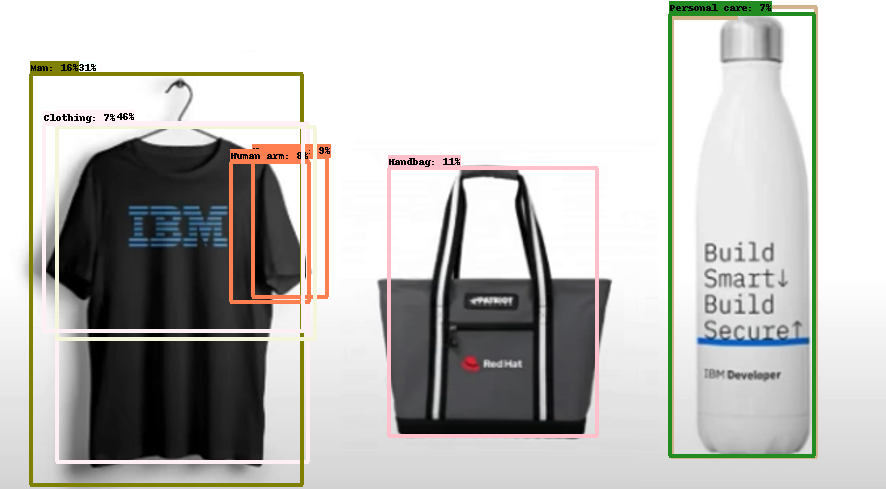

In [3]:
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont


def display_image(image):
    fig = plt.figure(figsize=(10, 10))
    plt.grid(False)
    plt.imshow(image)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)], width=thickness, fill=color)

    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str, fill="black", font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, detections):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())
    class_colors = {}
    font = ImageFont.load_default()
    image_pil = Image.open(image)

    for d in detections:
        display_str = "{}: {}%".format(d['class'], int(100 * d['score']))
        if not class_colors.get(d['class']):
            class_colors[d['class']] = colors[hash(d['class']) % len(colors)]
        color = class_colors.get(d['class'])
        draw_bounding_box_on_image(
            image_pil,
            d['box']['yMin'],
            d['box']['xMin'],
            d['box']['yMax'],
            d['box']['xMax'],
            color,
            font,
            display_str_list=[display_str])
    return image_pil
    image_pil.show()


draw_boxes(my_image, result['detections'])

## Extract the Predict function into Python files

Now that we've got a working function, extract the prediction logic into a standalone python file, `prediction.py` in a `predict` function.  Also, make sure `requirements.txt` is updated with any additional packages you've used and need for prediction.

## Test the function from your Python file

We can make sure the extraction worked properly by loading the function from our `prediction.py` file and testing it out to make sure it works the same.

[{'box': {'yMin': 0.015298157930374146, 'xMin': 0.7573940753936768, 'yMax': 0.9330282211303711, 'xMax': 0.9215428829193115}, 'class': 'Bottle', 'label': 'Bottle', 'score': 0.6573018431663513}, {'box': {'yMin': 0.25206586718559265, 'xMin': 0.06343632936477661, 'yMax': 0.9429852962493896, 'xMax': 0.34802669286727905}, 'class': 'Clothing', 'label': 'Clothing', 'score': 0.4687415659427643}, {'box': {'yMin': 0.15274754166603088, 'xMin': 0.034117892384529114, 'yMax': 0.9908268451690674, 'xMax': 0.34091490507125854}, 'class': 'Person', 'label': 'Person', 'score': 0.3141251802444458}, {'box': {'yMin': 0.15274754166603088, 'xMin': 0.034117892384529114, 'yMax': 0.9908268451690674, 'xMax': 0.34091490507125854}, 'class': 'Man', 'label': 'Man', 'score': 0.16677124798297882}, {'box': {'yMin': 0.34531813859939575, 'xMin': 0.43845587968826294, 'yMax': 0.8905516266822815, 'xMax': 0.674458920955658}, 'class': 'Handbag', 'label': 'Handbag', 'score': 0.11333320289850235}, {'box': {'yMin': 0.32310080528259

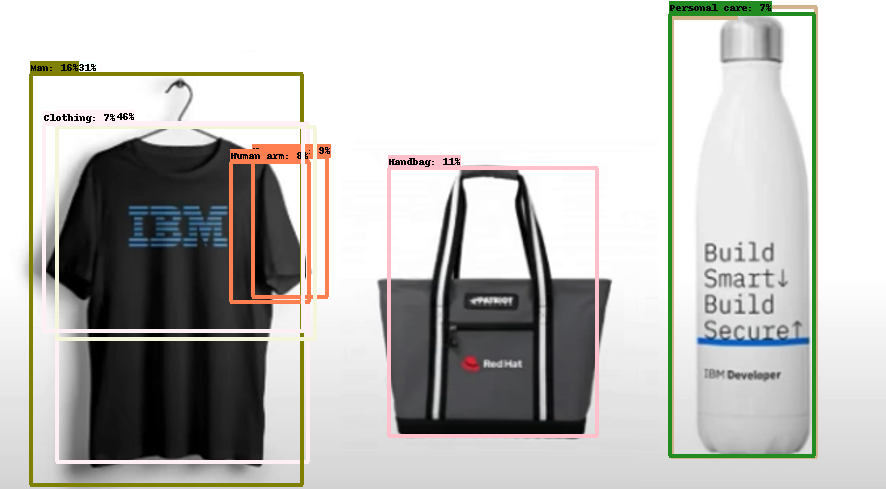

In [4]:
import json
from prediction import predict
import base64

#image file location.
my_image = 'retail.jpg'

with open(my_image, "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')
content = {"image": encoded_image}

result = predict(content)
print(result['detections'])
draw_boxes(my_image, result['detections'])